<a href="https://colab.research.google.com/github/uwituzeb/Career-Recommendation-Chatbot/blob/main/Career_Recommendation_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Career Recommendation ChatBot**

This project implements a domain-specific Career-Recommendation chatbot using a pre-trained language model fine-tuned on a career recommendation Q&A dataset. The chatbot is built to answer questions and provide accurate information about different career fields to guide students in choosing a career pathway and making informed choices.

In [ ]:
!pip install datasets transformers tensorflow rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5d0b387614be3cfb8bc663b1f9cc9d34392a4a28aa70ad8978b913eb7827e19d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFT5ForConditionalGeneration
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from rouge_score import rouge_scorer
import os
import re
import tensorflow as tf

# **Dataset Overview**

The dataset used provides career guidance information for a variety of career roles. It includes question and answer pairs related to differenct career roles, covering aspects like job responsibilities, skills, career progression, salary expectations and more.

Our dataset contains 1620 rows of question-answer pairs.

## **Columns**

**Role**: Name of career role, the dataset contains 54 career roles

**Question**: The question related to a career role

**Answer**: The answer to the asked question providing relevant information about the career role.


In [ ]:
# load dataset from hugging face
df = pd.read_csv("hf://datasets/Pradeep016/career-guidance-qa-dataset/Career QA Dataset.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# **Data Exploration**

In this section, we explored our career recommendation dataset using different statistics and viusalizations.

In [ ]:
# Inspect first rows of dataset
df.head()

,role,question,answer
0,Data Scientist,What does a Data Scientist do?,A Data Scientist extracts meaningful insights ...
1,Data Scientist,What are the main responsibilities of a Data S...,"Responsibilities include data cleaning, analyz..."
2,Data Scientist,What is the job description for a Data Scientist?,A Data Scientist is responsible for collecting...
3,Data Scientist,What skills are required to become a Data Scie...,Skills required include expertise in Python or...
4,Data Scientist,What are the essential skills for a successful...,A successful Data Scientist needs strong analy...


In [ ]:
# Summary of dataset
df.describe()

,role,question,answer
count,1620,1620,1620
unique,54,1620,1620
top,Data Scientist,How can I begin working as a Fundraising Manager?,Begin by applying for entry-level roles like F...
freq,30,1,1


In [ ]:
# Check for null values
# No missing values were found hence no need to handle them
df.isnull().sum()

,0
role,0
question,0
answer,0


In [ ]:
# Check for duplicated values
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
1615,False
1616,False
1617,False
1618,False


In [ ]:
df.shape

(1620, 3)

# Visualizations

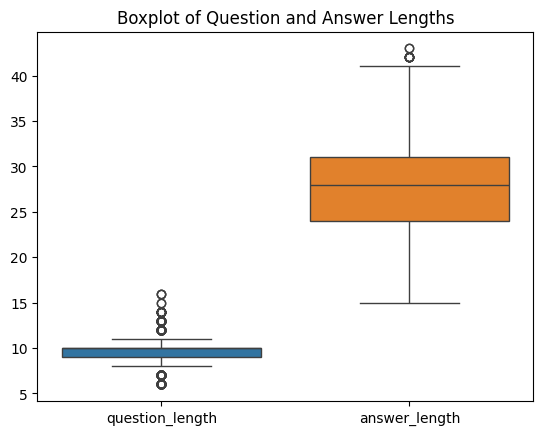

In [ ]:
# Distribution of question and answer lengths using boxplot
# This plot shows that question length is small with an average of 9-10 words while answers are longer with an average of 27-28 words with few outliers
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))

sns.boxplot(data=df[['question_length', 'answer_length']])
plt.title("Boxplot of Question and Answer Lengths")
plt.show()


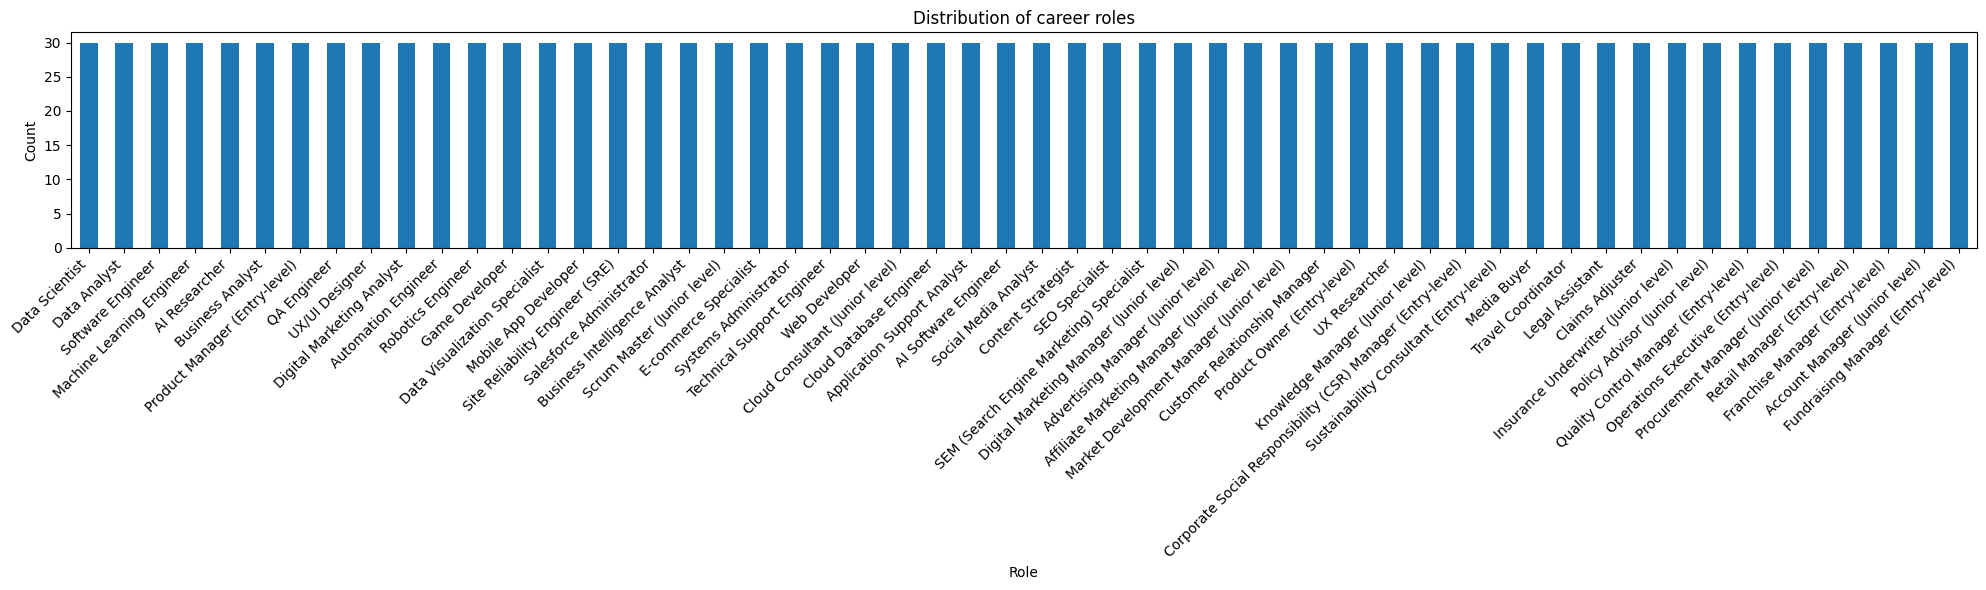

In [ ]:
# Role distribution
# From our plot, we can see that our dataset is balanced with all career roles having an average of 30 entries
# This will help in preventing biases in our model
plt.figure(figsize=(20, 6))
df['role'].value_counts().plot(kind='bar')
plt.title("Distribution of career roles")
plt.xlabel("Role")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# **Preprocessing**



In [ ]:
# Data cleaning

def clean_text(text):
    # Remove symbols, new lines and normalize whitespace
    text = re.sub(r'[^\w\s.,!?]', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply cleaning to dataset columns
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

In [ ]:
df['question'].iloc[0]

'What does a Data Scientist do?'

In [ ]:
df['answer'].iloc[0]

'A Data Scientist extracts meaningful insights from data by using advanced analytical techniques, statistical modeling, and machine learning to solve complex business problems.'

In [ ]:
# Convert to Hugging face dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)

In [ ]:
# Load model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFT5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
# Tokenization function
def tokenize_data(dataset):
    inputs = ["question: " + q for q in dataset["question"]]
    targets = dataset["answer"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Apply tokenization to dataset
tokenized_dataset = dataset.map(tokenize_data, batched=True, remove_columns=["question", "answer"])

Map:   0%|          | 0/1296 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

In [ ]:
# Split dataset into training and test sets
train_ds = tokenized_dataset["train"]
test_ds = tokenized_dataset["test"]

train_data = tf.data.Dataset.from_tensor_slices({
    "input_ids": train_ds["input_ids"],
    "attention_mask": train_ds["attention_mask"],
    "labels": train_ds["labels"],
}).batch(8)

test_data = tf.data.Dataset.from_tensor_slices({
    "input_ids": test_ds["input_ids"],
    "attention_mask": test_ds["attention_mask"],
    "labels": test_ds["labels"],
}).batch(8)

In [ ]:
# Compile and Train Model
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.01)
model.compile(optimizer=optimizer)
history = model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
162/162 [==============================] - 206s 690ms/step - loss: 5.3946 - val_loss: 0.7818
Epoch 2/10
162/162 [==============================] - 107s 663ms/step - loss: 0.8761 - val_loss: 0.6248
Epoch 3/10
162/162 [==============================] - 107s 661ms/step - loss: 0.7233 - val_loss: 0.5662
Epoch 4/10
162/162 [==============================] - 106s 653ms/step - loss: 0.6545 - val_loss: 0.5300
Epoch 5/10
162/162 [==============================] - 108s 669ms/step - loss: 0.6116 - val_loss: 0.5040
Epoch 6/10
162/162 [==============================] - 114s 707ms/step - loss: 0.5766 - val_loss: 0.4856
Epoch 7/10
162/162 [==============================] - 109s 671ms/step - loss: 0.5446 - val_loss: 0.4701
Epoch 8/10
162/162 [==============================] - 108s 669ms/step - loss: 0.5241 - val_loss: 0.4570
Epoch 9/10
162/162 [==============================] - 108s 669ms/step - loss: 0.5019 - val_loss: 0.4467
Epoch 10/10
162/162 [==============================] - 109s 671m

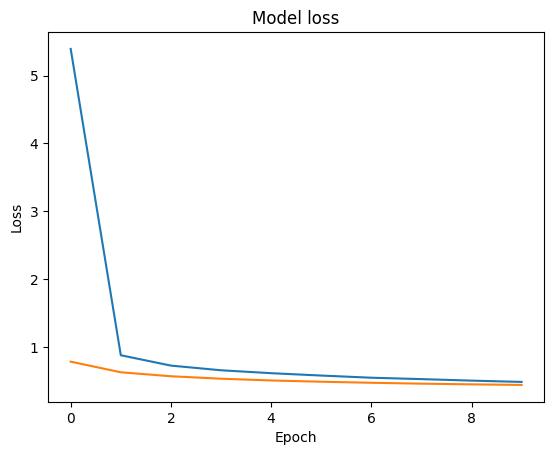

Final Training Loss: 0.48276761174201965
Final Validation Loss: 0.43837374448776245


In [ ]:
# Evaluate model training
train_loss = history.history["loss"][-1]
val_loss = history.history["val_loss"][-1]

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Print final training and validation loss
print(f"Final Training Loss: {train_loss}")
print(f"Final Validation Loss: {val_loss}")

In [ ]:
# Generate answer and handle questions irrelevant to our chatbot using confidence check
FALLBACK_RESPONSE = "Sorry, I am not able to answer that. Try asking a career-related question."

def generate_answer_with_confidence(model, tokenizer, question, threshold=-3.5, max_length=64):
    input_text = "question: " + question
    inputs = tokenizer(input_text, return_tensors="tf", padding="longest", truncation=True, max_length=128)

    # STEP 1: Generate answer
    output_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=3
    )
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Evaluate loss
    loss = model(input_ids=inputs["input_ids"], labels=output_ids).loss
    avg_log_prob = -loss.numpy()

    # Compare with threshold
    if avg_log_prob < threshold:
        return FALLBACK_RESPONSE, avg_log_prob
    else:
        return answer, avg_log_prob

user_question = "What is the weather like today?"
answer, confidence = generate_answer_with_confidence(model, tokenizer, user_question, threshold=-1.5)

print(f"Answer: {answer}")
print(f"Confidence (average log-prob): {float(confidence):.3f}")

Answer: Sorry, I am not able to answer that. Try asking a career-related question.
Confidence (average log-prob): -1.689


/tmp/ipython-input-28-483342569.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Confidence (average log-prob): {float(confidence):.3f}")


In [ ]:
!pip install evaluate nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import f1_score
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

In [ ]:
# Evaluate model using BLEU and f1-score
def evaluate_model(references, predictions):
   bleu_scores = []
   f1_scores = []

   for ref, pred in zip(references, predictions):
      # BLEU Score
        ref_tokens = ref.split()
        pred_tokens = pred.split()
        bleu_score = sentence_bleu([ref_tokens], pred_tokens)
        bleu_scores.append(bleu_score)

        # F1 Score
        common_tokens = set(ref_tokens) & set(pred_tokens)
        precision = len(common_tokens) / (len(pred_tokens) + 1e-8)
        recall = len(common_tokens) / (len(ref_tokens) + 1e-8)
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

        average_bleu = np.mean(bleu_scores)
        average_f1 = np.mean(f1_scores)

        return average_bleu, average_f1

In [ ]:
# Generate predictions
all_predictions = []
all_references = []

for batch in test_data:
    outputs = model.generate(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        max_length=64,
        num_beams=4,
        early_stopping=True
    )
    decoded_preds = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    decoded_labels = [tokenizer.decode(label, skip_special_tokens=True) for label in batch["labels"]]

    all_predictions.extend(decoded_preds)
    all_references.extend(decoded_labels)

average_bleu, average_f1 = evaluate_model(references, predictions)

print(f"Average BLEU Score: {average_bleu:.3f}")
print(f"Average F1 Score: {average_f1:.3f}")

Average BLEU Score: 0.090
Average F1 Score: 0.440


In [ ]:
# save model
model.save_pretrained("career-chatbot-t5")
tokenizer.save_pretrained("career-chatbot-t5")